In [274]:
import json
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from numpy import linalg as LA

import pandas as pd

import networkx as nx
import community

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

import pickle

In [275]:
baseline = "clusters_baseline_720_24.pkl" 
thresh = "clusters_thresh_720_24.pkl"
mst = "clusters_mst_720_24.pkl"
pmfg = "clusters_pmfg_720_24.pkl"

with open("../data/processed/"+baseline, 'rb') as f:
    baseline_clusters = pickle.load(f)
    
with open("../data/processed/"+thresh, 'rb') as f:
    thresh_clusters = pickle.load(f)

with open("../data/processed/"+mst, 'rb') as f:
    mst_clusters = pickle.load(f)
    
with open("../data/processed/"+pmfg, 'rb') as f:
    pmfg_clusters = pickle.load(f)

In [276]:
clustering_list = ["FULL", "THRESH", "PMFG", "MST"]

In [277]:
all_clustering = {"FULL":baseline_clusters, "THRESH": thresh_clusters, 
                  "PMFG":pmfg_clusters,"MST":mst_clusters }

## Stability

In [278]:
def compute_rand_score(clusters):
    nb_clusters = len(clusters.keys())
    rand_score = []
    for i in range(nb_clusters - 1):
        score = adjusted_rand_score(list(clusters[list(clusters.keys())[i]].values()), list(clusters[list(clusters.keys())[i+1]].values()))
        rand_score.append(score)
    return rand_score

In [279]:
def compute_nb_clusters(clusters):
    nb_clusters = len(clusters.keys())
    list_nb_clusters = []
    for i in range(nb_clusters - 1):
        nb = max(clusters[list(clusters.keys())[i]].values())
        list_nb_clusters.append(nb)
    return list_nb_clusters

In [280]:
clustering_sizes = {}
for i in range(len(clustering_list)):
    clustering_sizes[clustering_list[i]] = compute_nb_clusters(all_clustering[clustering_list[i]])

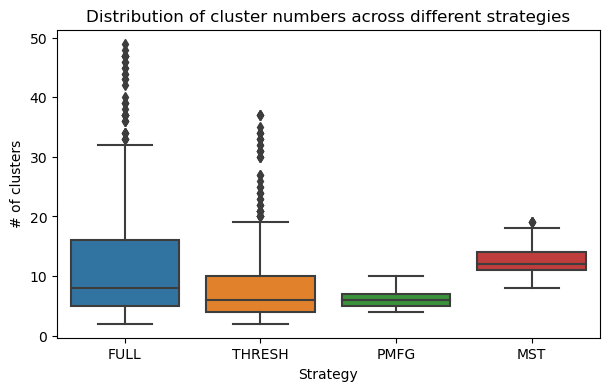

In [281]:
fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
#fig, axes = plt.subplots(figsize=(8,4))
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for size in clustering_sizes[c]],
                   'Value': [size for c in clustering_list for size in clustering_sizes[c]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel('# of clusters')
plt.title('Distribution of cluster numbers across different strategies')

# Show the plot
plt.show()

In [265]:
clustering_stability = {}
for i in range(len(clustering_list)):
    clustering_stability[clustering_list[i]] = compute_rand_score(all_clustering[clustering_list[i]])

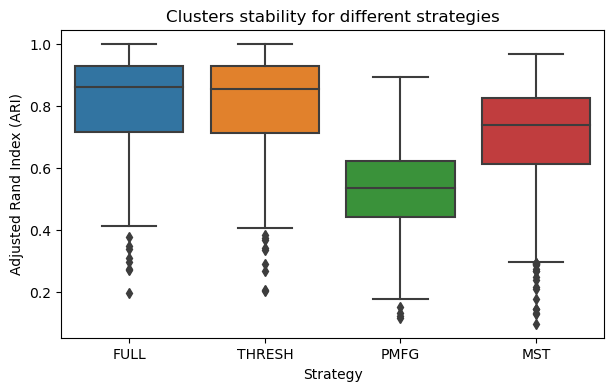

In [266]:
fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for s in clustering_stability[c]],
                   'Value': [s for c in clustering_list for s in clustering_stability[c]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.title('Clusters stability for different strategies')

# Show the plot
plt.show()

## Markowitz

In [254]:
def find_representatives(clusters):
    nb_clustering = len(clusters.keys())
    representatives = []
    for i in range(nb_clustering):
        
        current_representatives = []
        current_cluster = clusters[list(clusters.keys())[i]]

        # Loop through each community
        for group in range(max(current_cluster.values())):
            subset = [cluster[0] for cluster in current_cluster.items() if cluster[1] == group]
            # Subset the data for the current group
            subset_data = df[subset]

            # Apply PCA
            pca = PCA()
            principal_components = pca.fit_transform(subset_data)

            # Identify the leading coin (biggest contributor in the first principal component)
            leading_coin_index = np.argmax(np.abs(pca.components_[0]))
            leading_coin = subset_data.columns[leading_coin_index]
            current_representatives.append(leading_coin)
            # Print
        representatives.append(current_representatives)
    return representatives

In [255]:
def out_sample_risks(clusters, representatives):

    nb_clustering = len(clusters.keys())
    out_vol = []
    vol_abs = []
    for i in range(nb_clustering):
        length_window = list(clusters.keys())[i][1] - list(clusters.keys())[i][0]

        corr_mat_insample = df.loc[list(clusters.keys())[i][0]:list(clusters.keys())[i][1], representatives[i]].corr()
        corr_mat_outsample = df.loc[list(clusters.keys())[i][1]:list(clusters.keys())[i][1] + length_window, representatives[i]].corr()

        inv_corr_insample = LA.inv(corr_mat_insample.to_numpy())
        w_opt = inv_corr_insample @ np.ones(len(inv_corr_insample)) / (np.ones(len(inv_corr_insample)) @ inv_corr_insample @ np.ones(len(inv_corr_insample)))

        realized_vol = np.sqrt(w_opt @ corr_mat_insample @ w_opt.T)
        out_sample_vol = np.sqrt(w_opt @ corr_mat_outsample @ w_opt.T)
        out_vol.append(out_sample_vol)
        vol_abs.append(abs(realized_vol-out_sample_vol)/realized_vol)
    return (out_vol, vol_abs)

In [256]:
df = pd.read_csv("../data/processed/normalized_log_ret.csv")

In [257]:
clustering_out_vol = {}
for i in range(len(clustering_list)):
    representatives = find_representatives(all_clustering[clustering_list[i]])
    clustering_out_vol[clustering_list[i]] = out_sample_risks(all_clustering[clustering_list[i]], representatives)

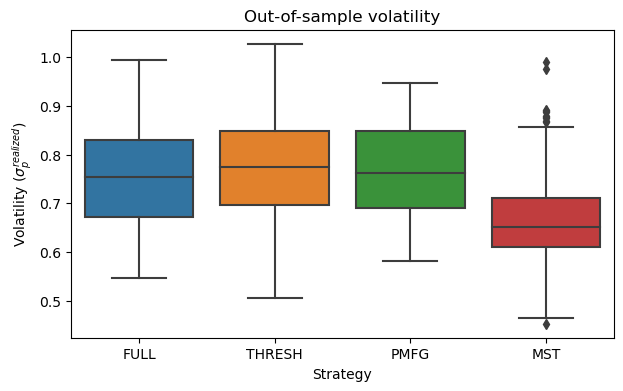

In [258]:
fig, axes = plt.subplots(figsize=(7,4))
# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for risk in clustering_out_vol[c][0]],
                   'Value': [s for c in clustering_list for s in clustering_out_vol[c][0]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel(r'Volatility ($\sigma_p^{realized}$)')
plt.title('Out-of-sample volatility')

# Show the plot
plt.show()

In [259]:
plt.rcParams.update(plt.rcParamsDefault)

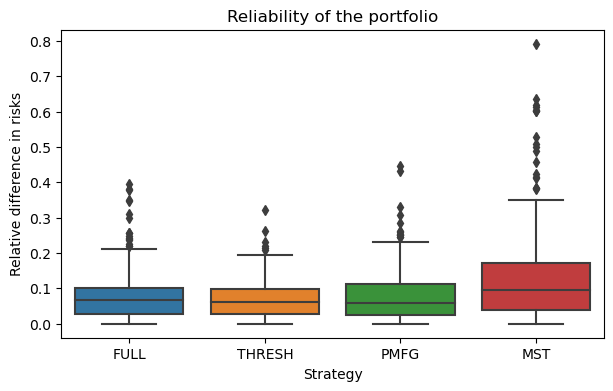

In [260]:
fig, axes = plt.subplots(figsize=(7,4))

# Combine the data in a single dataframe
df_plot = pd.DataFrame({'Group': [c for c in clustering_list for risk in clustering_out_vol[c][1]],
                   'Value': [s for c in clustering_list for s in clustering_out_vol[c][1]]})

# Create a boxplot with Seaborn
sns.boxplot(x='Group', y='Value', data=df_plot)

# Add labels and title
plt.xlabel('Strategy')
plt.ylabel(r'Relative difference in risks')
plt.title('Reliability of the portfolio')
#plt.yscale('log')
# Show the plot
plt.show()